# Potential

The electron beam interacts with the specimen through the Coulomb potential of the electrons and nuclei in the specimen. This tutorial shows how to create potentials using the independent atom model.

## Potential parametrization
Multislice simulation codes include a parametrization of the atomic potentials, with a table of parameters for each element. These parameters are typically found by fitting to first-principles calculations. Below we show the radial depedence of the electrostatic potential of five selected elements, using the default parametrization in abTEM. This parametrization is due to Lobato et. al., it is the latest and one of the most accurate parametrizations.

In [1]:
# This cell is hidden from nbsphinx

from abtem.parametrizations import lobato, load_lobato_parameters
import matplotlib.pyplot as plt
from ase.data import chemical_symbols
import numpy as np

parameters = load_lobato_parameters()
atomic_numbers = [6, 14, 29, 79, 92]
r = np.linspace(0,2,100)

for atomic_number in atomic_numbers:
    v = lobato(r, parameters[atomic_number])
    plt.plot(r, v, label=chemical_symbols[atomic_number])

plt.xlabel('r [Å]')
plt.ylabel('V [eV / e]')
plt.ylim([0, 30])
plt.legend()
plt.savefig('potentials.png')
plt.close()

The radial dependence of the atomic potential for isolated single atoms is shown below.

![potentials](potentials.png)

## Independent atom model

The full specimen potential, $V(r)$, is obtained as a linear superposition of the atomic potentials

$$
    V(r) = \sum_i V_i(r-r_i) \quad ,
$$

where $V_i(r)$ is the atomic potential of the $i$'th atom. This model obviously neglects any effect due to bonding and charge transfer. However, since the nucleus and core electrons constitute most of the charge in an atom, this is often reasonable approximation, which gets progressively better as the atomic number increases.

In abTEM, electrostatic potentials are represented using the `Potential` class. This class requires an ASE `Atoms` object for definig the atomic positions. The potential as the wave functions is defnied on a grid, hence the real space sampling in Angstrom should be given.

The `slice_thickness` parameter defines the spacing of potential slices used in the atomic potential. A smaller value improves the accuracy of the simulation, at additional computational cost. The default value of $0.5 \ \mathrm{Angstrom}$ is generally safe to use. The potentials have to be truncated at some distance from the core, this distance is calculated on a per species basis, from the `cutoff_tolerance` parameter, specifying the maximum allowed truncation error. The default value of $10^{-3} \ \mathrm{eV / e}$ is generally fine.

We create a potential from the atoms we imported in an earlier tutorial.

In [2]:
from ase.io import read
srtio3 = read('srtio3.cif')
srtio3 *= (2,2,3)
srtio3.center()
srtio3.center(axis=2, vacuum=3)

In [8]:
from abtem.potentials import Potential
potential = Potential(atoms=srtio3, 
                      sampling=.05, 
                      slice_thickness=0.5, 
                      cutoff_tolerance=1e-3,
                      method='finite',
                      parametrization='lobato')

## Potential projection

Many multislice codes projects the full range of the Coulomb potential of each atom into a single slice, this means that slices cannot be made thinner than about 1-2 Angstrom, and should always coincide with lattice planes. This method is also available in abTEM by setting the `method` parameter to `'infinite'`. By default the `method` parameter is set to `'finite'`, where the much more expensive finite integrals for each slice are calculated

$$
    V(x, y) = \int_{z}^{z + \Delta z} V(x,y,z') dz' \quad .
$$

These integrals are efficiently handled by using the double exponential [Tanh–Sinh quadrature](https://en.wikipedia.org/wiki/Tanh-sinh_quadrature), which is designed to give the most accurate result by using the minimum number of function evaluations and is suitable for functions with endpoint singularities.

We can plot three slices side-by-side from the potential as shown below:

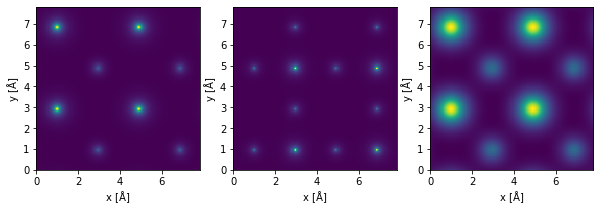

In [4]:
import matplotlib.pyplot as plt
from abtem.plot import plot_image

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
plot_image(potential.get_slice(5), cmap='viridis', ax=ax1)
plot_image(potential.get_slice(10), cmap='viridis', ax=ax2)
plot_image(potential.get_slice(15), cmap='viridis', ax=ax3)

## Precalculating the potential

When the `get_slice` method is called only one slice is calculated, hence the memory footprint is kept small. However, during a STEM simulation, each slice may be used multiple times. If the memory can be afforded, the potential should be precalculated, in order to speed up the simulation:

In [9]:
potential = potential.precalculate()

This stores the potential in memory as a numpy array, which can be accessed from the `array` property. The first dimension runs over slices.

In [10]:
potential.array.shape

(32, 157, 157)